# BME671L Final Exam Project

### Project Overview

This project focuses on developing a machine learning algorithm to categorize X-ray images. The primary goal is to differentiate between healthy lungs and those affected by pneumonia. Moreover, the project aims to distinguish between various types of pneumonia based on their infection sources.

### Data Description

The dataset includes 1,583 images of normal lungs, 1,493 instances of viral pneumonia, and 2,780 cases of bacterial pneumonia.

## Image File Collection and Preprocessing Steps

In the next phase, I will undertake the following tasks:

1. **Image Importation**: Gather the X-ray image files of normal lungs, viral pneumonia, and bacterial pneumonia.

2. **Image Resizing**: Adjust all images to a uniform size of 256x256 pixels. This step is crucial for ensuring consistency in the data fed into the machine learning model.

3. **Normalization**: Apply normalization to the image data. This process adjusts the pixel values to a common scale, enhancing the model's ability to learn effectively from the data.

4. **Dataset Splitting**: Divide the resized and normalized images into three subsets: training, validation, and testing datasets. This split is essential for training the model, tuning hyperparameters, and evaluating its performance.

5. **Data Saving**: Save the prepared datasets for subsequent use in machine learning tasks.

Upon successful completion of these steps, this code section will be finalized, and I will proceed to the next stage of the project.

In [1]:
import subprocess
import sys

# Define the required packages and their pip install names if different
required_packages = {
    "torch": "torch",
    "torchvision": "torchvision",
    "numpy": "numpy",
    "pandas": "pandas",
    "matplotlib": "matplotlib",
    "PIL": "Pillow",
    "tqdm": "tqdm",
    "sklearn": "scikit-learn"
    # Add other packages as necessary
}

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

for package, install_name in required_packages.items():
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        install_packages = input(f"{package} is not installed. Would you like to install it now? (yes/no): ").strip().lower()
        if install_packages == 'yes':
            print(f"Installing {package}.")
            install(install_name)
        else:
            print(f"Skipping installation of {package}. Please note that the following code may not work without this package.")

print("All package checks complete.")


torch is already installed.
torchvision is already installed.
numpy is already installed.
pandas is already installed.
matplotlib is already installed.
PIL is already installed.
tqdm is already installed.
sklearn is already installed.
All package checks complete.


In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    mean_squared_error, mean_absolute_error, r2_score, 
    accuracy_score, precision_score, recall_score, f1_score
)

In [3]:
def process_images(image_ids, types, base_image_path, target_path):
    for image_id, image_type in tqdm(zip(image_ids, types), total=len(image_ids), desc="Processing Images"):
        image_path = os.path.join(base_image_path, image_id + '.jpeg')  # Assuming the images are in .jpeg format
        image = Image.open(image_path)
        image = image.resize((256, 256))
        image_array = np.array(image) / 255.0  # Normalize to [0, 1]

        # Convert array back to image
        processed_image = Image.fromarray((image_array * 255).astype(np.uint8))

        save_path = os.path.join(target_path, image_type)
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        processed_image.save(os.path.join(save_path, image_id + '.png'))  # Save as .png

In [4]:
# Load metadata and split dataset
metadata_path = '/Users/zhixiangyao/Downloads/chest_xray/Lung_metadata.csv'
base_image_path = '/Users/zhixiangyao/Downloads/chest_xray/Images/'
metadata = pd.read_csv(metadata_path)

# Split the data into train, validation, and test sets
train_val, test = train_test_split(metadata, test_size=0.15, random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, random_state=42)  # Adjusts to keep train:val:test as 70:15:15

# Process each set and save in respective folders
process_images(train['image_id'], train['Type'], base_image_path, os.path.join('/Users/zhixiangyao/Downloads/chest_xray/', 'Train'))
process_images(val['image_id'], val['Type'], base_image_path, os.path.join('/Users/zhixiangyao/Downloads/chest_xray/', 'Val'))
process_images(test['image_id'], test['Type'], base_image_path, os.path.join('/Users/zhixiangyao/Downloads/chest_xray/', 'Test'))


Processing Images: 100%|██████████| 879/879 [00:35<00:00, 24.58it/s]


## Data Summary

The summary of the original dataset is provided in a pie chart

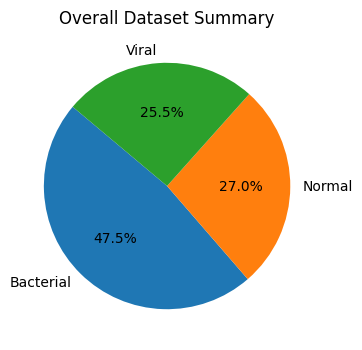

In [5]:
def plot_dataset_summary(metadata, title):
    """
    Plot a summary of the dataset using a pie chart.
    """
    # Count the occurrences of each type
    type_counts = metadata['Type'].value_counts()

    # Create a pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

plot_dataset_summary(metadata, 'Overall Dataset Summary')


## Machine Learning

### Case 1: identify healthy lungs and pneumonia images.

Now, let's get started with the classification. To start with, we will first try to identify the health cases and the pneumonia cases.

In [6]:
def create_dataset(root_dir, transform):
    dataset = ImageFolder(root=root_dir, transform=transform)
    # Change labels: 0 for 'Normal', 1 for 'Not Normal'
    for i, (data, label) in enumerate(dataset.samples):
        if dataset.classes[label] != 'Normal':
            dataset.samples[i] = (data, 1)
        else:
            dataset.samples[i] = (data, 0)
    return dataset

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
data_dir = "/Users/zhixiangyao/Downloads/chest_xray/"

In [9]:
train_data_1 = create_dataset(os.path.join(data_dir, 'Train'), transform)
val_data_1 = create_dataset(os.path.join(data_dir, 'Val'), transform)
test_data_1 = create_dataset(os.path.join(data_dir, 'Test'), transform)

train_loader_1 = DataLoader(train_data_1, batch_size=32, shuffle=True)
val_loader_1 = DataLoader(val_data_1, batch_size=32, shuffle=False)
test_loader_1 = DataLoader(test_data_1, batch_size=32, shuffle=False)

In [10]:
# Define the neural network model
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 64),  # Assuming the images are resized to 256x256 and have 3 color channels
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [11]:
# Instantiate the model
model_1 = SimpleANN()

# Define loss function and optimizer
loss_func = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0004)

In [12]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model_1.train()  # Set the model to training mode
    train_loss = 0.0
    for batch, (X, y) in enumerate(train_loader_1):
        # Compute prediction and loss
        pred = model_1(X)
        loss = loss_func(pred, y.unsqueeze(1).type_as(pred))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model_1.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for X, y in val_loader_1:
            pred = model_1(X)
            loss = loss_func(pred, y.unsqueeze(1).type_as(pred))
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader_1)
    avg_val_loss = val_loss / len(val_loader_1)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

# Save the trained model
torch.save(model_1.state_dict(), 'lung_health_classifier.pth')


Epoch 1/10, Train Loss: 0.2539681377504815, Val Loss: 0.23807118793151208
Epoch 2/10, Train Loss: 0.16959224904114886, Val Loss: 0.21315658169000276
Epoch 3/10, Train Loss: 0.1555230690332404, Val Loss: 0.19203120110822575
Epoch 4/10, Train Loss: 0.12324898443527722, Val Loss: 0.17687794579459087
Epoch 5/10, Train Loss: 0.11584929574656394, Val Loss: 0.21158930512943439
Epoch 6/10, Train Loss: 0.10761762804229015, Val Loss: 0.18838678859174252
Epoch 7/10, Train Loss: 0.08874449811789185, Val Loss: 0.27015266193692306
Epoch 8/10, Train Loss: 0.09195361778775389, Val Loss: 0.2117466696404985
Epoch 9/10, Train Loss: 0.10717916720756149, Val Loss: 0.19187428334927453
Epoch 10/10, Train Loss: 0.08087616315194543, Val Loss: 0.33883481888499645


In [13]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            predictions = outputs.round()  # Round to 0 or 1
            y_true.extend(y.tolist())
            y_pred.extend(predictions.squeeze(1).tolist())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

In [14]:
# Evaluate the model on the test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(model_1, test_loader_1)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.9089874857792947
Precision: 0.9818181818181818
Recall: 0.8852459016393442
F1 Score: 0.9310344827586207
Confusion Matrix:
[[259  10]
 [ 70 540]]


### Case 2: Classify X-ray images among healthy, bacterial and viral pneumonia

In [15]:
train_data_2 = ImageFolder(root=os.path.join(data_dir, 'Train'), transform=transform)
val_data_2 = ImageFolder(root=os.path.join(data_dir, 'Val'), transform=transform)
test_data_2 = ImageFolder(root=os.path.join(data_dir, 'Test'), transform=transform)

train_loader_2 = DataLoader(train_data_2, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(val_data_2, batch_size=32, shuffle=False)
test_loader_2 = DataLoader(test_data_2, batch_size=32, shuffle=False)

In [16]:
# Define the neural network model
class SimpleANN_2(nn.Module):
    def __init__(self):
        super(SimpleANN_2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [17]:
# Instantiate the model
model_2 = SimpleANN_2()

# Define loss function and optimizer
loss_func_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0004)

In [18]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model_2.train()  # Set the model to training mode
    train_loss_2 = 0.0
    for batch, (X, y) in enumerate(train_loader_2):
        optimizer_2.zero_grad()
        pred_2 = model_2(X)
        loss_2 = loss_func_2(pred_2, y)  # Use pred_2 here
        loss_2.backward()
        optimizer_2.step()
        train_loss_2 += loss_2.item()

    # Validation phase
    model_2.eval()  # Set the model to evaluation mode
    val_loss_2 = 0.0
    with torch.no_grad():
        for X, y in val_loader_2:
            pred_2 = model_2(X)  # Use pred_2 for consistency
            loss_2 = loss_func_2(pred_2, y)  # Use pred_2 here
            val_loss_2 += loss_2.item()

    # Calculate average losses
    avg_train_loss_2 = train_loss_2 / len(train_loader_2)
    avg_val_loss_2 = val_loss_2 / len(val_loader_2)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_2}, Val Loss: {avg_val_loss_2}")

# Save the trained model
torch.save(model_2.state_dict(), 'lung_health_classifier_2.pth')

Epoch 1/10, Train Loss: 0.8012225322945173, Val Loss: 0.581271514828716
Epoch 2/10, Train Loss: 0.6256275241689164, Val Loss: 0.6390704150710788
Epoch 3/10, Train Loss: 0.5575422762438308, Val Loss: 0.6828192568251065
Epoch 4/10, Train Loss: 0.5494386398977087, Val Loss: 0.5636776938502278
Epoch 5/10, Train Loss: 0.5342804372541664, Val Loss: 0.5608259066939354
Epoch 6/10, Train Loss: 0.48479050548039665, Val Loss: 0.6313824403498854
Epoch 7/10, Train Loss: 0.48658334550469423, Val Loss: 0.5872859228402376
Epoch 8/10, Train Loss: 0.4574806984773902, Val Loss: 0.5914924174015012
Epoch 9/10, Train Loss: 0.46231585764145666, Val Loss: 0.5621229468711785
Epoch 10/10, Train Loss: 0.42681024310200716, Val Loss: 0.5989060702600649


In [19]:
# Model evaluation
def evaluate_model_2(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(predictions.tolist())

    report = classification_report(y_true, y_pred, target_names=train_data_2.classes)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return report, conf_matrix

report_2, conf_matrix_2 = evaluate_model_2(model_2, test_loader_2)
print(report_2)
print(f'Confusion Matrix:\n{conf_matrix_2}')

              precision    recall  f1-score   support

   Bacterial       0.81      0.76      0.78       396
      Normal       0.93      0.87      0.90       269
       Viral       0.56      0.68      0.61       214

    accuracy                           0.77       879
   macro avg       0.77      0.77      0.77       879
weighted avg       0.79      0.77      0.78       879

Confusion Matrix:
[[299   8  89]
 [  8 235  26]
 [ 60   9 145]]


### Case 3: Applying Fourier Transformation to the model

In [20]:
class FourierLayer(nn.Module):
    def __init__(self, mask_size):
        super(FourierLayer, self).__init__()
        self.mask = nn.Parameter(torch.ones(1, 1, mask_size, mask_size))

    def forward(self, x):
        # Apply Fourier Transform
        x = torch.fft.fft2(x, norm='ortho')
        x = torch.fft.fftshift(x)

        # Apply the trainable mask
        x = x * self.mask

        # Inverse Fourier Transform (optional)
        x = torch.fft.ifftshift(x)
        x = torch.fft.ifft2(x, norm='ortho')

        return x.real

In [21]:
class SimpleANNWithFourier(nn.Module):
    def __init__(self):
        super(SimpleANNWithFourier, self).__init__()
        self.fourier = FourierLayer(256)  # For 256x256 images
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        x = self.fourier(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [22]:
model_3 = SimpleANNWithFourier()
loss_func_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.0004)

In [23]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model_3.train()  # Set the model to training mode
    train_loss_3 = 0.0
    for batch, (X, y) in enumerate(train_loader_2):
        optimizer_3.zero_grad()
        pred_3 = model_3(X)
        loss_3 = loss_func_3(pred_3, y)  # Use pred_3 here
        loss_3.backward()
        optimizer_3.step()
        train_loss_3 += loss_3.item()

    # Validation phase
    model_3.eval()  # Set the model to evaluation mode
    val_loss_3 = 0.0
    with torch.no_grad():
        for X, y in val_loader_2:
            pred_3 = model_3(X)  # Use pred_3 for consistency
            loss_3 = loss_func_3(pred_3, y)  # Use pred_3 here
            val_loss_3 += loss_3.item()

    # Calculate average losses
    avg_train_loss_3 = train_loss_3 / len(train_loader_2)
    avg_val_loss_3 = val_loss_3 / len(val_loader_2)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_3}, Val Loss: {avg_val_loss_3}")

# Save the trained model
torch.save(model_3.state_dict(), 'lung_health_classifier_3.pth')

Epoch 1/10, Train Loss: 0.7217405431492384, Val Loss: 0.5839208372469459
Epoch 2/10, Train Loss: 0.597855580580789, Val Loss: 0.5755700431764126
Epoch 3/10, Train Loss: 0.5428698552671329, Val Loss: 0.5534275014485631
Epoch 4/10, Train Loss: 0.511189187912978, Val Loss: 0.5584620500781706
Epoch 5/10, Train Loss: 0.5003285872381787, Val Loss: 0.5113199840166739
Epoch 6/10, Train Loss: 0.47818768890791163, Val Loss: 0.5651126003691128
Epoch 7/10, Train Loss: 0.49571678481360737, Val Loss: 0.5416729051087584
Epoch 8/10, Train Loss: 0.4525505779094474, Val Loss: 0.5803280122844237
Epoch 9/10, Train Loss: 0.4326014529133952, Val Loss: 0.7297303415502289
Epoch 10/10, Train Loss: 0.4241086571484573, Val Loss: 0.6108591376271632


In [24]:
report_3, conf_matrix_3 = evaluate_model_2(model_3, test_loader_2)
print(report_3)
print(f'Confusion Matrix:\n{conf_matrix_3}')

              precision    recall  f1-score   support

   Bacterial       0.83      0.72      0.77       396
      Normal       0.85      0.96      0.90       269
       Viral       0.56      0.60      0.58       214

    accuracy                           0.77       879
   macro avg       0.75      0.76      0.75       879
weighted avg       0.77      0.77      0.76       879

Confusion Matrix:
[[286  17  93]
 [  2 258   9]
 [ 57  28 129]]


In [25]:
def evaluate_and_show_filtered_examples(model, data_loader, num_examples=6):
    model.eval()
    images, filtered_images, labels, predictions = [], [], [], []

    # Randomly select images from the data loader
    all_indices = list(range(len(data_loader.dataset)))
    selected_indices = random.sample(all_indices, min(num_examples, len(all_indices)))

    with torch.no_grad():
        for i in selected_indices:
            # Directly access the dataset
            X, y = data_loader.dataset[i]
            X = X.unsqueeze(0)  # Add batch dimension

            # Original image in grayscale
            original_image = X[0].mean(dim=0)

            # Fourier Transform of the image
            image_fft = torch.fft.fft2(original_image)
            image_fft_shifted = torch.fft.fftshift(image_fft)

            # Fourier filter (from the model)
            fourier_filter = model.fourier.mask.data.squeeze()

            # Apply the Fourier filter
            filtered_fft = image_fft_shifted * fourier_filter
            filtered_fft_shifted = torch.fft.ifftshift(filtered_fft)
            filtered_image = torch.fft.ifft2(filtered_fft_shifted).real

            _, predicted = torch.max(model(X), 1)

            # Append original and filtered images
            images.append(original_image)  # Original image
            filtered_images.append(filtered_image)  # Filtered image
            labels.append(y)
            predictions.extend(predicted.tolist())

        # Display images with predictions
        class_names = data_loader.dataset.classes
        plt.figure(figsize=(15, 6))
        for i in range(len(images)):
            # Original image
            plt.subplot(1, len(images), i + 1)
            plt.imshow(images[i].numpy(), cmap='gray')
            plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}')
            plt.axis('off')

            # # Filtered image
            # plt.subplot(2, len(images), len(images) + i + 1)
            # plt.imshow(filtered_images[i].numpy(), cmap='gray')
            # plt.title(f'Filtered\nPredicted: {class_names[predictions[i]]}')
            plt.axis('off')

        plt.show()

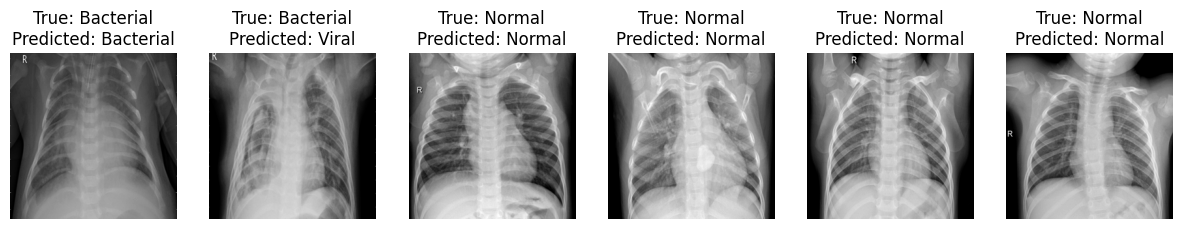

In [26]:
evaluate_and_show_filtered_examples(model_3, test_loader_2)

In [27]:
def plot_fourier_analysis(model, data_loader, num_examples=1):
    model.eval()

    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            if i >= num_examples:
                break

            # Original image in grayscale
            original_image = X[0].mean(dim=0)

            # Fourier Transform of the image
            image_fft = torch.fft.fft2(original_image)
            image_fft_shifted = torch.fft.fftshift(image_fft)

            # Fourier filter (assuming it's already in the frequency domain)
            fourier_filter = model.fourier.mask.data.squeeze()
            
            fourier_filter_shifted = torch.fft.ifftshift(fourier_filter)
            fourier_filter_image = torch.fft.ifft2(fourier_filter_shifted).real

            # Apply the Fourier filter
            filtered_fft = image_fft_shifted * fourier_filter
            filtered_fft_shifted = torch.fft.ifftshift(filtered_fft)
            filtered_image = torch.fft.ifft2(filtered_fft_shifted).real

            # Plotting
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))

            # Time domain plots
            axes[0, 0].imshow(original_image.numpy(), cmap='gray')
            axes[0, 0].set_title("Original Image")
            axes[0, 0].axis('off')

            # The filter is visualized in the frequency domain
            axes[0, 1].imshow(torch.log(torch.abs(fourier_filter) + 1).numpy(), cmap='gray')
            axes[0, 1].set_title("Fourier Filter")
            axes[0, 1].axis('off')

            axes[0, 2].imshow(filtered_image.numpy(), cmap='gray')
            axes[0, 2].set_title("Filtered Image")
            axes[0, 2].axis('off')

            # Frequency domain plots (Magnitude and Phase)
            for j, data in enumerate([(image_fft_shifted, "Image"),
                                      (fourier_filter_image, "Filter"),
                                      (filtered_fft, "Filtered Image")]):
                magnitude = torch.log(torch.abs(data[0]) + 1).numpy()
                phase = torch.angle(data[0]).numpy()

                axes[1, j].imshow(magnitude, cmap='gray')
                axes[1, j].set_title(f"Magnitude of {data[1]}")
                axes[1, j].axis('off')

                axes[2, j].imshow(phase, cmap='gray')
                axes[2, j].set_title(f"Phase of {data[1]}")
                axes[2, j].axis('off')

            plt.show()

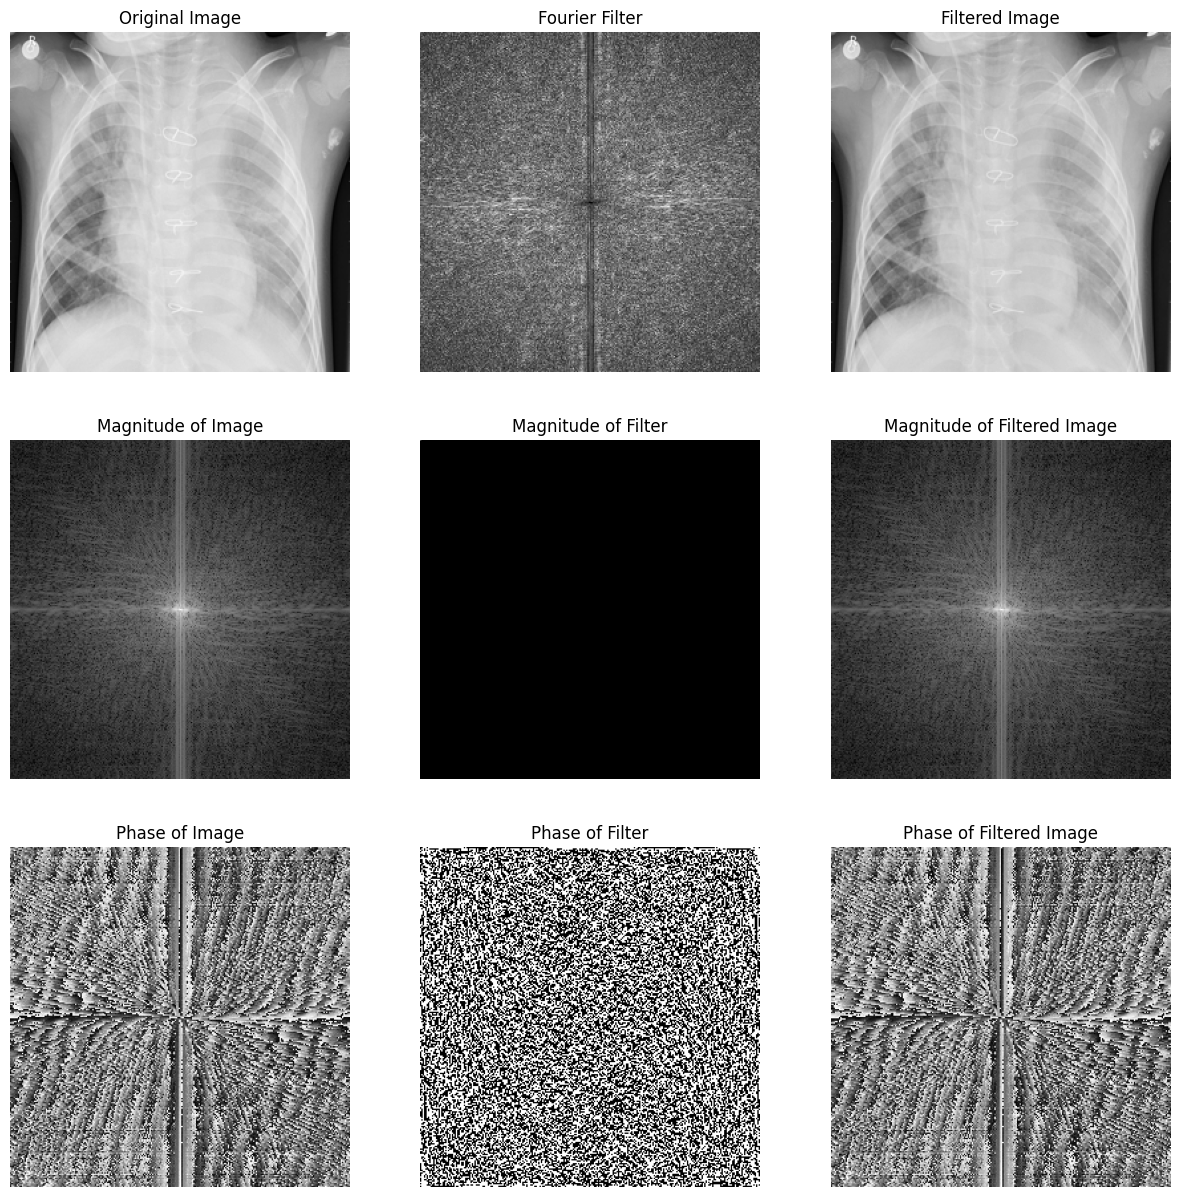

In [28]:
plot_fourier_analysis(model_3, test_loader_2)

### Case 4: LPF

In [29]:
class FourierTrainableLPFLayer(nn.Module):
    def __init__(self, size, initial_radius):
        super(FourierTrainableLPFLayer, self).__init__()
        self.size = size
        self.radius = nn.Parameter(torch.tensor([initial_radius], dtype=torch.float32))

    def forward(self, x):
        # Apply Fourier Transform
        x = torch.fft.fft2(x, norm='ortho')
        x = torch.fft.fftshift(x)

        # Generate LPF mask dynamically based on current radius
        L, M = self.size, self.size
        x_center, y_center = L // 2, M // 2
        X, Y = torch.meshgrid(torch.arange(L), torch.arange(M), indexing="xy")
        mask = ((X - x_center) ** 2 + (Y - y_center) ** 2 <= self.radius ** 2).to(x.device)

        # Apply the LPF mask
        x = x * mask

        # Inverse Fourier Transform
        x = torch.fft.ifftshift(x)
        x = torch.fft.ifft2(x, norm='ortho')

        return x.real

In [30]:
class SimpleANNWithTrainableLPF(nn.Module):
    def __init__(self):
        super(SimpleANNWithTrainableLPF, self).__init__()
        self.fourier = FourierTrainableLPFLayer(256, 50)  # Initial radius example
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        x = self.fourier(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [31]:
model_4 = SimpleANNWithTrainableLPF()
loss_func_4 = nn.CrossEntropyLoss()
optimizer_4 = optim.Adam(model_4.parameters(), lr=0.0004)

In [32]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model_4.train()  # Set the model to training mode
    train_loss_4 = 0.0
    for batch, (X, y) in enumerate(train_loader_2):
        optimizer_4.zero_grad()
        pred_4 = model_4(X)
        loss_4 = loss_func_4(pred_4, y)
        loss_4.backward()
        optimizer_4.step()
        train_loss_4 += loss_4.item()

    # Validation phase
    model_4.eval()  # Set the model to evaluation mode
    val_loss_4 = 0.0
    with torch.no_grad():
        for X, y in val_loader_2:
            pred_4 = model_4(X)
            loss_4 = loss_func_4(pred_4, y)
            val_loss_4 += loss_4.item()

    # Calculate average losses
    avg_train_loss_4 = train_loss_4 / len(train_loader_2)
    avg_val_loss_4 = val_loss_4 / len(val_loader_2)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_4}, Val Loss: {avg_val_loss_4}")

# Save the trained model
torch.save(model_4.state_dict(), 'lung_health_classifier_4.pth')

Epoch 1/10, Train Loss: 0.7632153461607851, Val Loss: 0.7872475666393127
Epoch 2/10, Train Loss: 0.636089601026949, Val Loss: 0.5915836447051593
Epoch 3/10, Train Loss: 0.5918129794588385, Val Loss: 0.5764348669243711
Epoch 4/10, Train Loss: 0.5254960064740144, Val Loss: 0.5352856107056141
Epoch 5/10, Train Loss: 0.507013836110285, Val Loss: 0.5640810885732728
Epoch 6/10, Train Loss: 0.49959279192510503, Val Loss: 0.5480203862701144
Epoch 7/10, Train Loss: 0.4902993029402208, Val Loss: 0.6683439248840192
Epoch 8/10, Train Loss: 0.4607700512621754, Val Loss: 0.5952095771873636
Epoch 9/10, Train Loss: 0.44430328709210537, Val Loss: 0.6015239512281758
Epoch 10/10, Train Loss: 0.45374685780022495, Val Loss: 0.5409238315852625


In [33]:
report_4, conf_matrix_4 = evaluate_model_2(model_4, test_loader_2)
print(report_4)
print(f'Confusion Matrix:\n{conf_matrix_4}')

              precision    recall  f1-score   support

   Bacterial       0.78      0.84      0.81       396
      Normal       0.88      0.95      0.91       269
       Viral       0.67      0.50      0.57       214

    accuracy                           0.79       879
   macro avg       0.77      0.76      0.76       879
weighted avg       0.78      0.79      0.78       879

Confusion Matrix:
[[332  17  47]
 [  8 255   6]
 [ 88  19 107]]


In [34]:
def evaluate_and_show_examples(model, data_loader, num_examples=6):
    model.eval()
    images, filtered_images, labels, predictions = [], [], [], []

    # Randomly select images from the data loader
    all_indices = list(range(len(data_loader.dataset)))
    selected_indices = random.sample(all_indices, min(num_examples, len(all_indices)))

    with torch.no_grad():
        for i in selected_indices:
            # Directly access the dataset
            X, y = data_loader.dataset[i]
            X = X.unsqueeze(0)  # Add batch dimension

            # Apply the model to get the filtered image
            filtered_image = model(X)

            _, predicted = torch.max(filtered_image, 1)

            # Append original and filtered images
            images.append(X.squeeze(0))  # Original image
            filtered_images.append(filtered_image.squeeze(0))  # Filtered image
            labels.append(y)
            predictions.extend(predicted.tolist())

        # Display images with predictions
        class_names = data_loader.dataset.classes
        plt.figure(figsize=(15, 6))
        for i in range(len(images)):
            # Original image
            plt.subplot(1, len(images), i + 1)
            plt.imshow(images[i].mean(dim=0).numpy(), cmap='gray')  # Convert to grayscale
            plt.title(f'True: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}')
            plt.axis('off')

        plt.show()

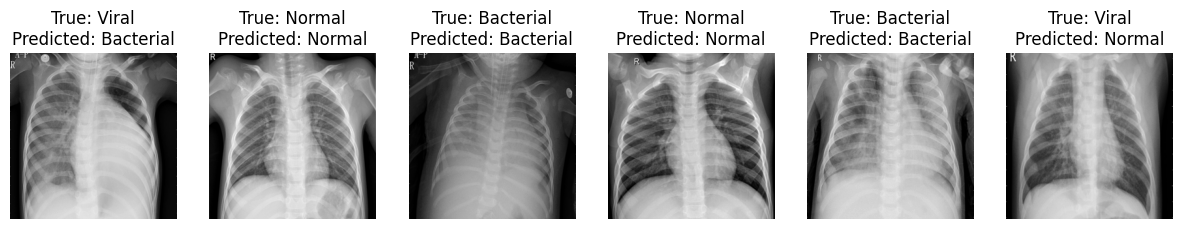

In [35]:
evaluate_and_show_examples(model_4, test_loader_2)

In [36]:
def plot_fourier_analysis_2(model, data_loader, num_examples=1):
    model.eval()

    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            if i >= num_examples:
                break

            # Original image in grayscale
            original_image = X[0].mean(dim=0)

            # Fourier Transform of the image
            image_fft = torch.fft.fft2(original_image)
            image_fft_shifted = torch.fft.fftshift(image_fft)

            # Creating the LPF mask
            fourier_filter_radius = model.fourier.radius.item()
            L, M = original_image.shape
            X, Y = torch.meshgrid(torch.arange(L), torch.arange(M), indexing="xy")
            filter_mask = ((X - L // 2) ** 2 + (Y - M // 2) ** 2 <= fourier_filter_radius ** 2).float()

            # Apply the Fourier filter
            filtered_fft = image_fft_shifted * filter_mask
            filtered_fft_shifted = torch.fft.ifftshift(filtered_fft)
            filtered_image = torch.fft.ifft2(filtered_fft_shifted).real

            # Plotting
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))

            # Time domain plots
            axes[0, 0].imshow(original_image.numpy(), cmap='gray')
            axes[0, 1].imshow(filter_mask.numpy(), cmap='gray')
            axes[0, 2].imshow(filtered_image.numpy(), cmap='gray')

            # Titles for time domain plots
            titles = ['Original Image', 'Fourier Filter (LPF)', 'Filtered Image']
            for ax, title in zip(axes[0], titles):
                ax.set_title(title)
                ax.axis('off')

            # Frequency domain plots (Magnitude and Phase)
            data_list = [(image_fft_shifted, "Image"), (filter_mask, "Filter"), (filtered_fft, "Filtered Image")]
            for j, (data, label) in enumerate(data_list):
                magnitude = torch.log(torch.abs(data) + 1).numpy()
                phase = torch.angle(data).numpy()

                axes[1, j].imshow(magnitude, cmap='gray')
                axes[1, j].set_title(f"Magnitude of {label}")
                axes[1, j].axis('off')

                axes[2, j].imshow(phase, cmap='gray')
                axes[2, j].set_title(f"Phase of {label}")
                axes[2, j].axis('off')

            plt.show()

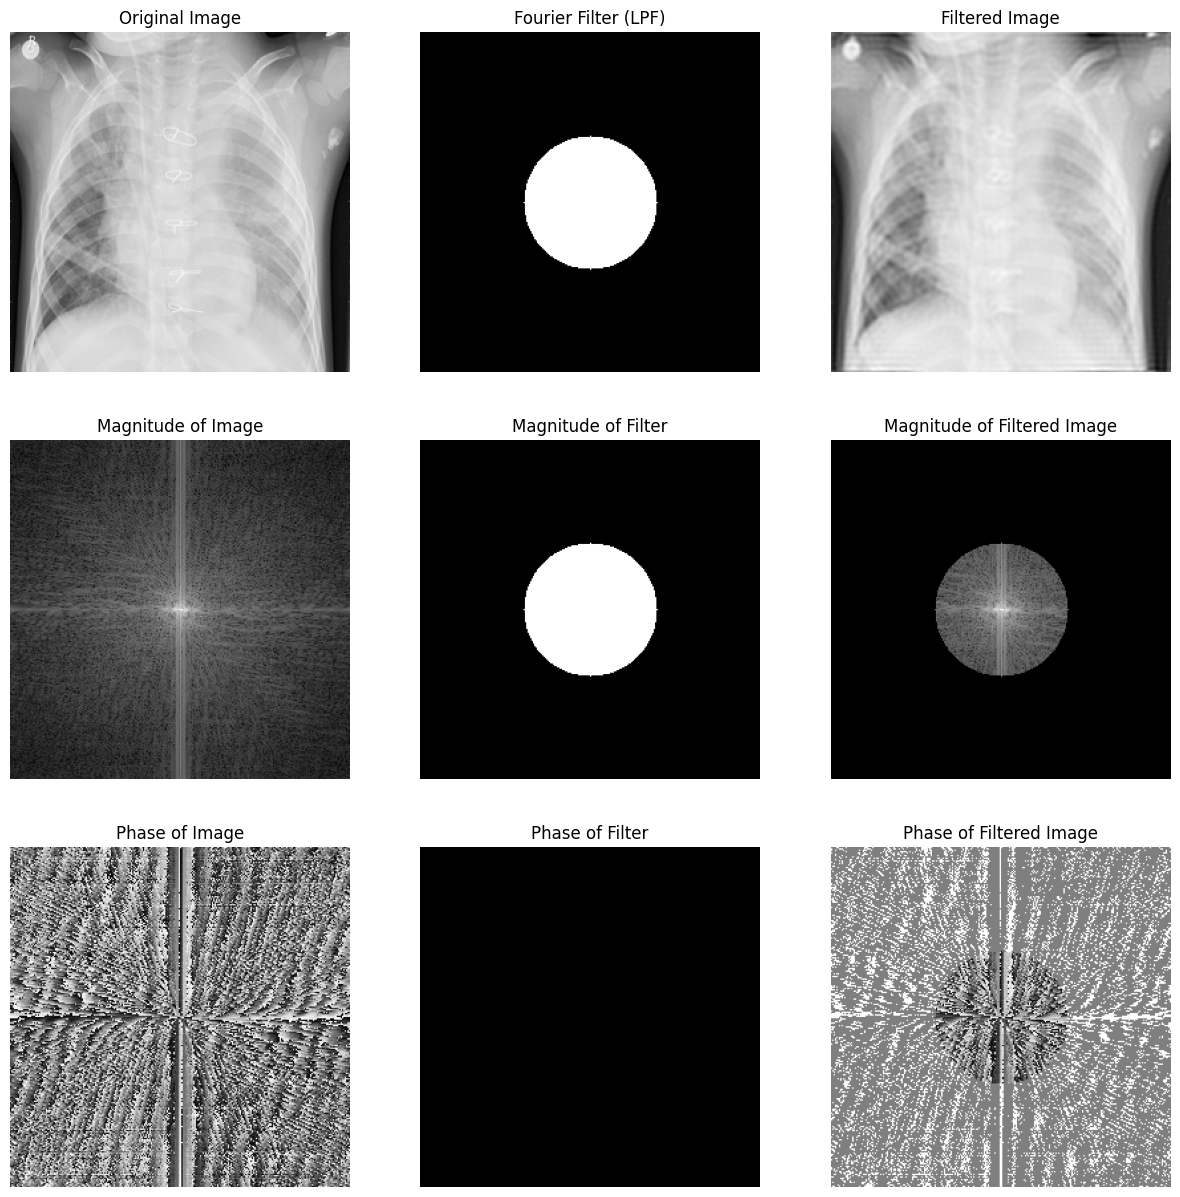

In [37]:
plot_fourier_analysis_2(model_4, test_loader_2)

### Case 5: HPF

In [38]:
class FourierTrainableHPFLayer(nn.Module):
    def __init__(self, size, initial_radius):
        super(FourierTrainableHPFLayer, self).__init__()
        self.size = size
        self.radius = nn.Parameter(torch.tensor([initial_radius], dtype=torch.float32))

    def forward(self, x):
        # Apply Fourier Transform
        x = torch.fft.fft2(x, norm='ortho')
        x = torch.fft.fftshift(x)

        # Generate HPF mask dynamically based on current radius
        L, M = self.size, self.size
        x_center, y_center = L // 2, M // 2
        X, Y = torch.meshgrid(torch.arange(L), torch.arange(M), indexing="xy")
        mask = ((X - x_center) ** 2 + (Y - y_center) ** 2 >= self.radius ** 2).float().to(x.device)

        # Apply the HPF mask
        x = x * mask

        # Inverse Fourier Transform
        x = torch.fft.ifftshift(x)
        x = torch.fft.ifft2(x, norm='ortho')

        return x.real


In [39]:
class SimpleANNWithTrainableHPF(nn.Module):
    def __init__(self):
        super(SimpleANNWithTrainableHPF, self).__init__()
        self.fourier = FourierTrainableHPFLayer(256, 50)  # Initial radius example
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256*256*3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 3)
        )

    def forward(self, x):
        x = self.fourier(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [40]:
model_5 = SimpleANNWithTrainableHPF()
loss_func_5 = nn.CrossEntropyLoss()
optimizer_5 = optim.Adam(model_5.parameters(), lr=0.0004)

In [41]:
# Training loop with validation
epochs = 10
for epoch in range(epochs):
    model_5.train()  # Set the model to training mode
    train_loss_5 = 0.0
    for batch, (X, y) in enumerate(train_loader_2):
        optimizer_5.zero_grad()
        pred_5 = model_5(X)
        loss_5 = loss_func_5(pred_5, y)
        loss_5.backward()
        optimizer_5.step()
        train_loss_5 += loss_5.item()

    # Validation phase
    model_5.eval()  # Set the model to evaluation mode
    val_loss_5 = 0.0
    with torch.no_grad():
        for X, y in val_loader_2:
            pred_5 = model_5(X)
            loss_5 = loss_func_5(pred_5, y)
            val_loss_5 += loss_5.item()

    # Calculate average losses
    avg_train_loss_5 = train_loss_5 / len(train_loader_2)
    avg_val_loss_5 = val_loss_5 / len(val_loader_2)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss_5}, Val Loss: {avg_val_loss_5}")

# Save the trained model
torch.save(model_5.state_dict(), 'lung_health_classifier_5.pth')

Epoch 1/10, Train Loss: 0.8939745800439701, Val Loss: 0.7694105207920074
Epoch 2/10, Train Loss: 0.4607099005880282, Val Loss: 0.8389548818979945
Epoch 3/10, Train Loss: 0.1453642197776326, Val Loss: 1.0898345676915986
Epoch 4/10, Train Loss: 0.03543621419690723, Val Loss: 1.2910827717610769
Epoch 5/10, Train Loss: 0.010183235353342611, Val Loss: 1.4705445830311095
Epoch 6/10, Train Loss: 0.003264596266581771, Val Loss: 1.5844008039150919
Epoch 7/10, Train Loss: 0.0016307560044526693, Val Loss: 1.6582453006080218
Epoch 8/10, Train Loss: 0.0010306580055797429, Val Loss: 1.7353008751358305
Epoch 9/10, Train Loss: 0.0007002502938149525, Val Loss: 1.79558400703328
Epoch 10/10, Train Loss: 0.0005026084845596852, Val Loss: 1.8625728988221713


In [42]:
report_5, conf_matrix_5 = evaluate_model_2(model_5, test_loader_2)
print(report_5)
print(f'Confusion Matrix:\n{conf_matrix_5}')

              precision    recall  f1-score   support

   Bacterial       0.64      0.76      0.69       396
      Normal       0.81      0.65      0.73       269
       Viral       0.52      0.48      0.50       214

    accuracy                           0.66       879
   macro avg       0.66      0.63      0.64       879
weighted avg       0.66      0.66      0.66       879

Confusion Matrix:
[[299  28  69]
 [ 66 176  27]
 [100  12 102]]


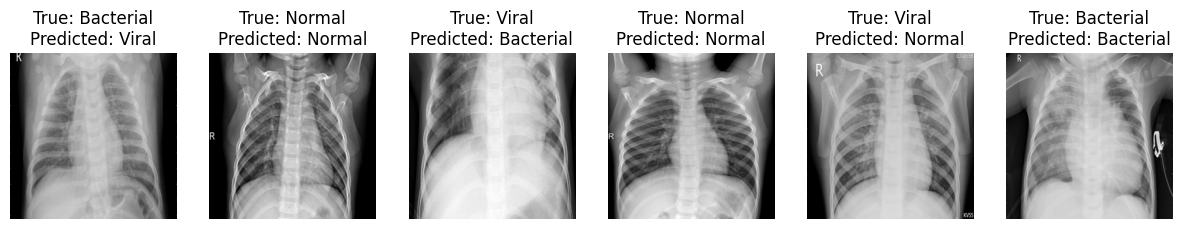

In [43]:
evaluate_and_show_examples(model_5, test_loader_2)

In [44]:
import matplotlib.pyplot as plt

def plot_fourier_analysis_3(model, data_loader, num_examples=1):
    model.eval()

    with torch.no_grad():
        for i, (X, y) in enumerate(data_loader):
            if i >= num_examples:
                break

            # Original image in grayscale
            original_image = X[0].mean(dim=0)

            # Fourier Transform of the image
            image_fft = torch.fft.fft2(original_image)
            image_fft_shifted = torch.fft.fftshift(image_fft)

            # Creating the HPF mask
            fourier_filter_radius = model.fourier.radius.item()
            L, M = original_image.shape
            X, Y = torch.meshgrid(torch.arange(L), torch.arange(M), indexing="xy")
            filter_mask = ((X - L // 2) ** 2 + (Y - M // 2) ** 2 >= fourier_filter_radius ** 2).float()

            # Apply the Fourier filter
            filtered_fft = image_fft_shifted * filter_mask
            filtered_fft_shifted = torch.fft.ifftshift(filtered_fft)
            filtered_image = torch.fft.ifft2(filtered_fft_shifted).real

            # Plotting
            fig, axes = plt.subplots(3, 3, figsize=(15, 15))

            # Time domain plots
            axes[0, 0].imshow(original_image.numpy(), cmap='gray')
            axes[0, 0].set_title("Original Image")
            axes[0, 0].axis('off')

            axes[0, 1].imshow(filter_mask.numpy(), cmap='gray')
            axes[0, 1].set_title("Fourier Filter (HPF)")
            axes[0, 1].axis('off')

            # Filtered image in the second row, centered
            axes[0, 2].imshow(filtered_image.numpy(), cmap='gray')
            axes[0, 2].set_title("Filtered Image")
            axes[0, 2].axis('off')

            # Leave the first and third plots in the second row empty
            axes[1, 0].axis('off')
            axes[1, 2].axis('off')

            # Frequency domain plots (Magnitude and Phase)
            data_list = [(image_fft_shifted, "Image"), (filter_mask, "Filter"), (filtered_fft, "Filtered Image")]
            for j, (data, label) in enumerate(data_list):
                magnitude = torch.log(torch.abs(data) + 1).numpy()
                phase = torch.angle(data).numpy()

                axes[1, j].imshow(magnitude, cmap='gray')
                axes[1, j].set_title(f"Magnitude of {label}")
                axes[1, j].axis('off')

                axes[2, j].imshow(phase, cmap='gray')
                axes[2, j].set_title(f"Phase of {label}")
                axes[2, j].axis('off')

            plt.show()

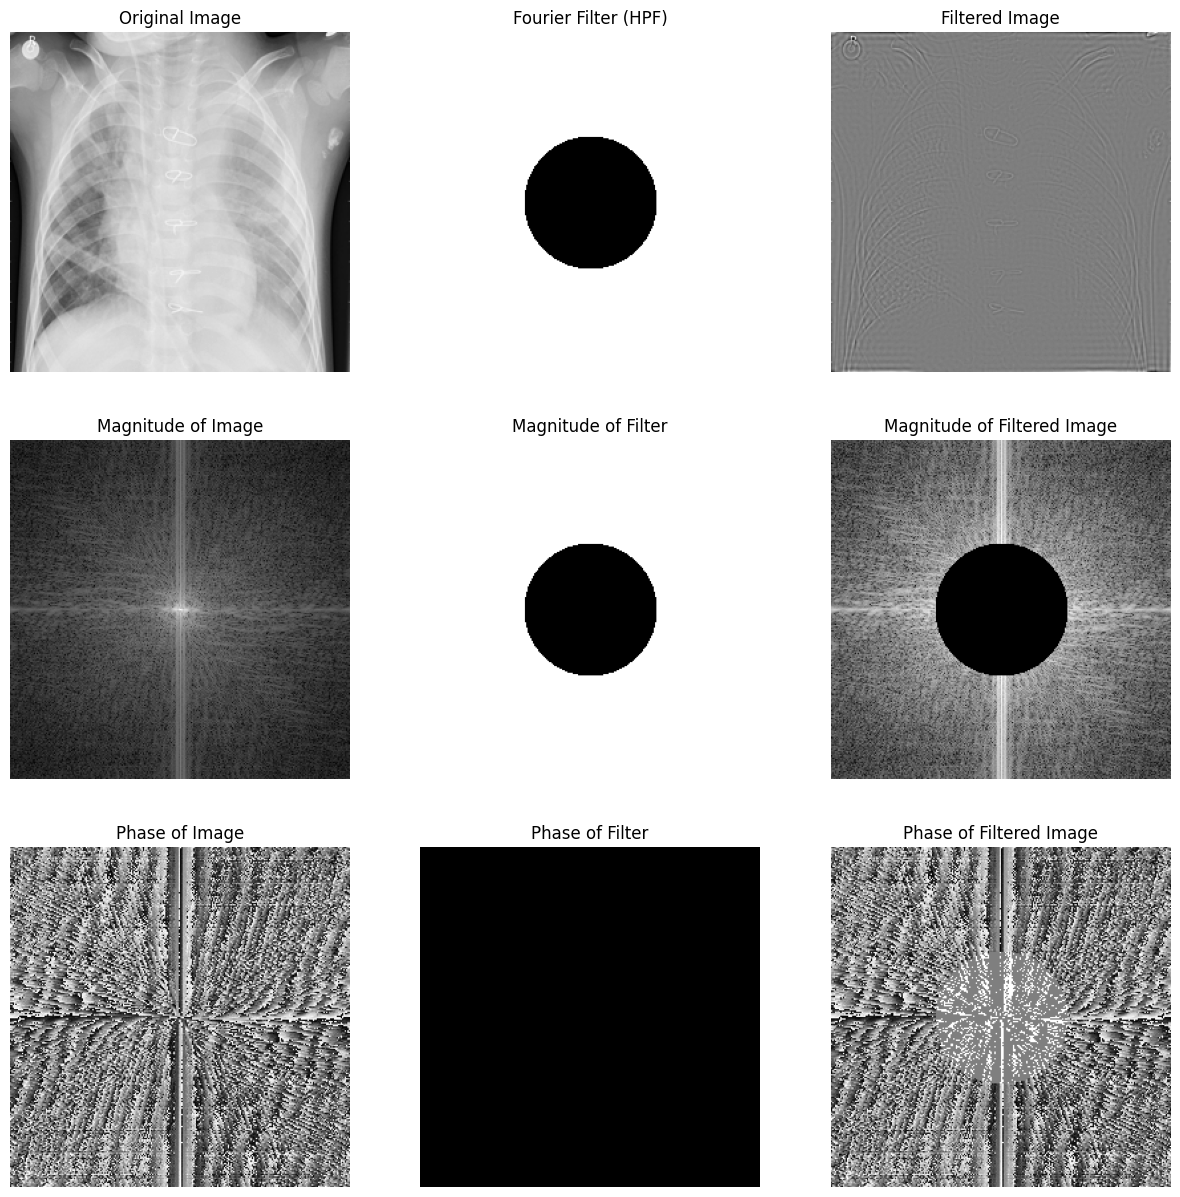

In [45]:
plot_fourier_analysis_3(model_5, test_loader_2)